<a href="https://colab.research.google.com/github/miamvmian/SciML/blob/main/Seminar_3_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import torch

from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [ ]:
cat = np.load('cat.npy')

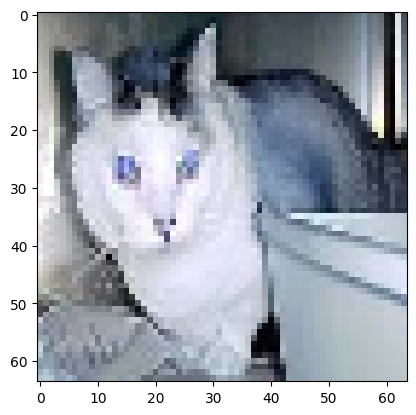

In [ ]:
plt.imshow(cat)

In [ ]:
x_mesh, y_mesh = np.arange(64), np.arange(64)
x_mesh, y_mesh = np.meshgrid(x_mesh, y_mesh, indexing='ij')

In [ ]:
coords = np.stack((x_mesh, y_mesh)).reshape(2, -1).T
values = np.transpose(cat, (2, 0, 1)).reshape(3, -1).T

In [ ]:
values = values / 255
coords = coords / 64

In [ ]:
pd.DataFrame({
    'x': coords[:, 0],
    'y': coords[:, 1],
    'r': values[:, 0],
    'g': values[:, 1],
    'b': values[:, 2]
})

,x,y,r,g,b
0,0.000000,0.000000,0.572549,0.576471,0.560784
1,0.000000,0.015625,0.533333,0.537255,0.521569
2,0.000000,0.031250,0.517647,0.521569,0.505882
3,0.000000,0.046875,0.482353,0.486275,0.470588
4,0.000000,0.062500,0.462745,0.466667,0.450980
...,...,...,...,...,...
4091,0.984375,0.921875,0.721569,0.756863,0.772549
4092,0.984375,0.937500,0.725490,0.760784,0.776471
4093,0.984375,0.953125,0.729412,0.764706,0.780392
4094,0.984375,0.968750,0.733333,0.768627,0.784314


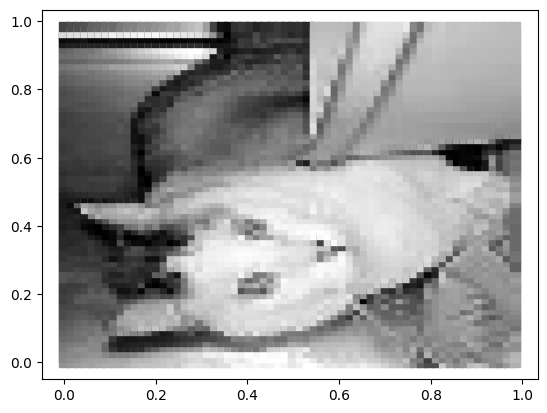

In [ ]:
plt.scatter(coords[:, 0], coords[:, 1], c=values[:, 0], s=50, marker='s', cmap='grey')

# Model

In [ ]:
class MLP(nn.Module):

    def __init__(self) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            nn.LazyLinear(out_features=256),
            nn.Tanh(),
            nn.Linear(in_features=256, out_features=256),
            nn.Tanh(),
            nn.Linear(in_features=256, out_features=3),
            nn.Sigmoid()
        )

    def forward(self, X):
        return self.layers(X)

In [ ]:
mlp = MLP()

In [ ]:
next(iter(mlp.layers[0].parameters()))

In [ ]:
with torch.inference_mode():
  print(mlp.layers[:2][X])

In [ ]:
BATCH_SIZE = 16

X_train, X_val, y_train, y_val = train_test_split(
    torch.from_numpy(coords).type(torch.float32),
    torch.from_numpy(values).type(torch.float32),
    test_size=0.2
)

train_dataloader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(TensorDataset(X_val, y_val), shuffle=True, batch_size=BATCH_SIZE)

In [ ]:
X, y = next(iter(train_dataloader))

In [ ]:
device = 'cuda'
mlp = mlp.to(device)

In [ ]:
optimizer = Adam(mlp.parameters(), lr=0.0001, weight_decay=0.01)
mse_loss = nn.MSELoss(reduction='mean')

In [ ]:
def r2(real, pred):
    return (1.0 - torch.mean(torch.square(real - pred)) / torch.var(real)).item()

In [ ]:
N_EPOCH = 1000

train_losses = list()
val_losses = list()

pbar = tqdm(range(N_EPOCH))

for epoch in pbar:

    train_loss = list()
    val_loss = list()
    scores = list()

    mlp.train()
    for X, y in train_dataloader:
        X = X.to(device)
        y = y.to(device)
        y_hat = mlp(X)
        loss = mse_loss(y, y_hat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    train_losses.append(np.mean(train_loss))

    mlp.eval()
    with torch.inference_mode(): # without calculate gradient
        for X, y in train_dataloader:
            X = X.to(device)
            y = y.to(device)
            y_hat = mlp(X)
            loss = mse_loss(y, y_hat)

            val_loss.append(loss.item())
            scores.append(r2(y, y_hat))

    val_losses.append(np.mean(val_loss))
    avg_score = np.mean(scores)
    pbar.set_description(f'Score: {avg_score:.2f}')

Score: -0.06: 100%|██████████| 1000/1000 [08:17<00:00,  2.01it/s]


In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)

In [ ]:
coords_torch = torch.from_numpy(coords).type(torch.float32)
coords_torch = coords_torch.to(device)
mlp.eval()
with torch.inference_mode():
    values_pred = mlp(coords_torch).detach().cpu().numpy()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(values.reshape(64, 64, 3))

ax2.imshow(values_pred.reshape(64, 64, 3))